# Assumed absence dark diversity modelling

Assumed absence dark diversity is an approach to spatially modelling species dark diversity, or local absence despite being in the species pool.

This approach is named "assumed absence" because it relies on the assumption that if a species is not observed in a location, then it is assumed to be absent, unless there is evidence to the contrary (i.e. occurrence records). We assume absent unless proven present.

This approach is counter to most methods of modelling species distributions, where we assume present unless proven absent. The main reason for this is the extreme imbalance in number of presence records to absence records, by many orders of magnitude. Absence records are generally only collected in structured plot-based surveys, which the vast majority of species occurrence records. The lack of absence data means that we cannot reliably model the absence of species in a location, as we do not have enough to do so. 

However, given that modelling species dark diversity entirely depends on known presences and absences, we must assume absence in locations where we do not have occurrence records.

This approach takes 3 main stages:
1. Model the species pool using environmental data and species co-occurrence information.
2. Use occurrence records to model the known presence of a species
3. Subtract the known presence from the species pool to get the assumed absence dark diversity.

## Simulation study

To test out this method and if it can recreate patterns of known dark diversity, we can simulate a simple species pool across a landscape, and then occurrence records.



In [308]:
library(terra)
set.seed(8647)
# Strength of the dark diversity covariate
strength <- 0.8
# Threshold for presence absence
threshold <- 0.6
# Threshold for dark diversity
dark_threshold <- 0.5
# Number of plot points to sample PA
n_plots <- 100
# Number of presence only points to sample
n_pts <- 1000
# Sigma bandwidth for the KDE
sigma <- 5

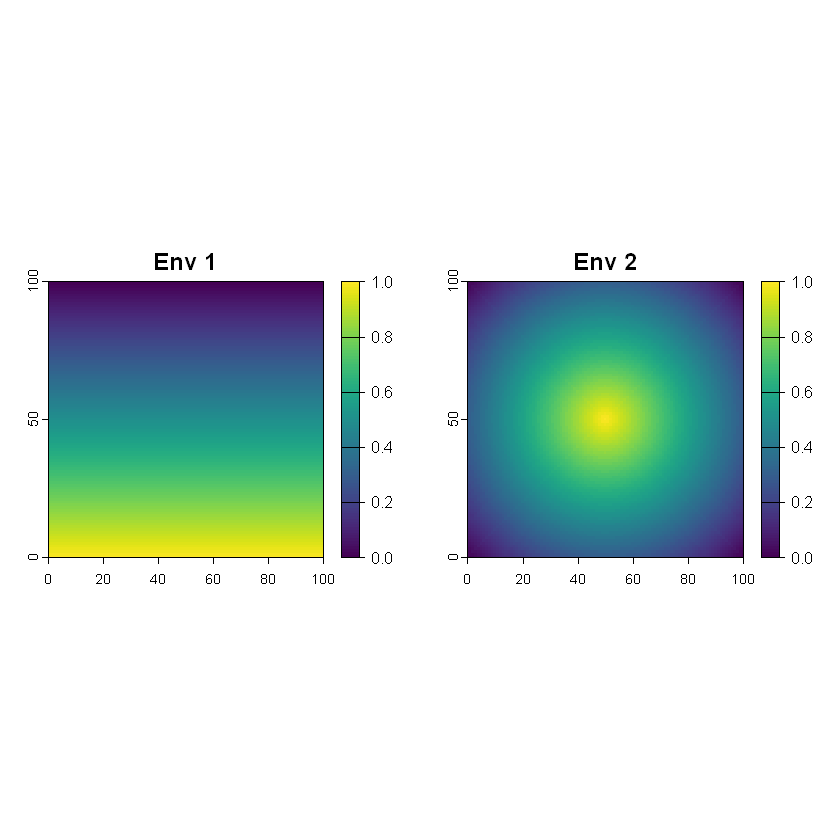

In [309]:
env_1 <- terra::rast(nrows = 100, ncols = 100, ext = c(0, 100, 0, 100))
terra::res(env_1) <- 1
values(env_1) <- seq(0, 1, length.out = ncell(env_1))

# Create a second raster with a radial gradient
env_2 <- rast(nrows = 100, ncols = 100, ext = c(0, 100, 0, 100))
res(env_2) <- 1

# Calculate the distance from the center for each cell
center_x <- ncol(env_2) / 2
center_y <- nrow(env_2) / 2

cols <- 1:ncol(env_2)
rows <- 1:nrow(env_2)

# Create a matrix of x and y coordinates
coords_x <- matrix(cols, nrow = nrow(env_2), ncol = ncol(env_2), byrow = TRUE)
coords_y <- matrix(rows, nrow = nrow(env_2), ncol = ncol(env_2), byrow = FALSE)

# Calculate the distance from the center for each cell
distance <- sqrt((coords_x - center_x)^2 + (coords_y - center_y)^2)

# Normalize the distance to be between 0 and 1
values(env_2) <- 1 - distance / max(distance)

# Rescale the values to be between 0 and 100
env_1 <- env_1 / max(values(env_1))
env_2 <- env_2 / max(values(env_2))

par(bg = "white", mfrow = c(1, 2))  # Set the background color and layout
# Use image to create the heatmap

plot(env_1, main = "Env 1")
plot(env_2, main = "Env 2")

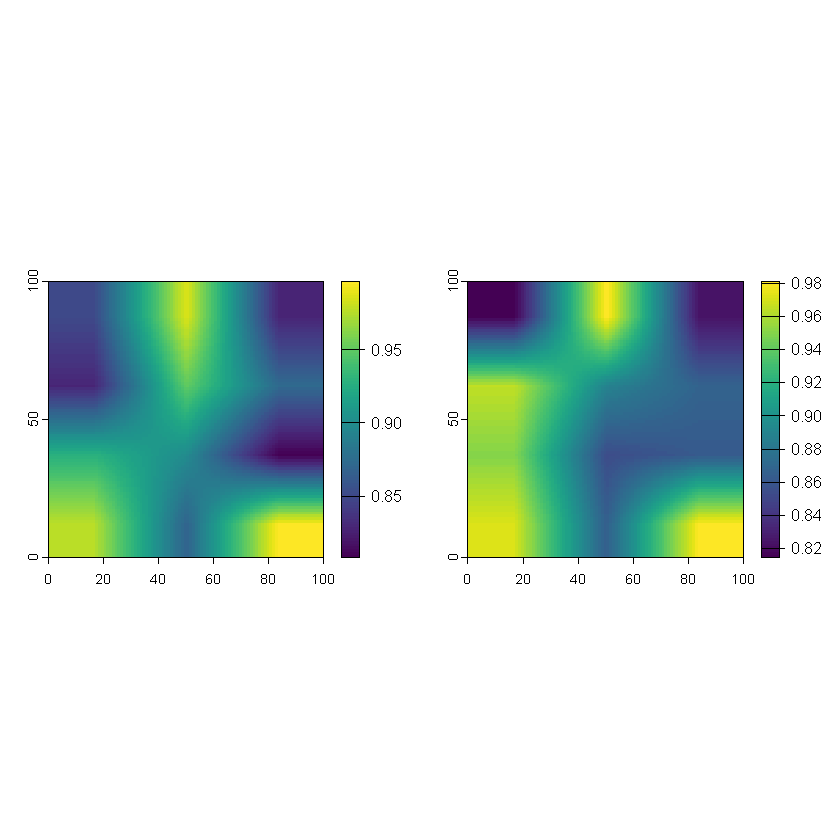

In [310]:
strength <- 0.8

# Lets generate two drivers of dark diversity
par(mfrow = c(1, 2),bg =  "white")
d1 <- rast(ext(env_1), nrows = 4, ncols = 3)
values(d1) <- runif(ncell(d1), strength, 1)
d1 <- resample(d1, env_1)
plot(d1)

d2 <- rast(ext(env_1), nrows = 4, ncols = 3)
values(d2) <- runif(ncell(d2), strength, 1)
d2 <- resample(d2, env_1, "cubic")
plot(d2)

Now, lets make three virtual species by defining some response functions to the two environmental covariates. We need to make these species distributions first, which we can then draw from to calculate the species pool and dark diveristy. 

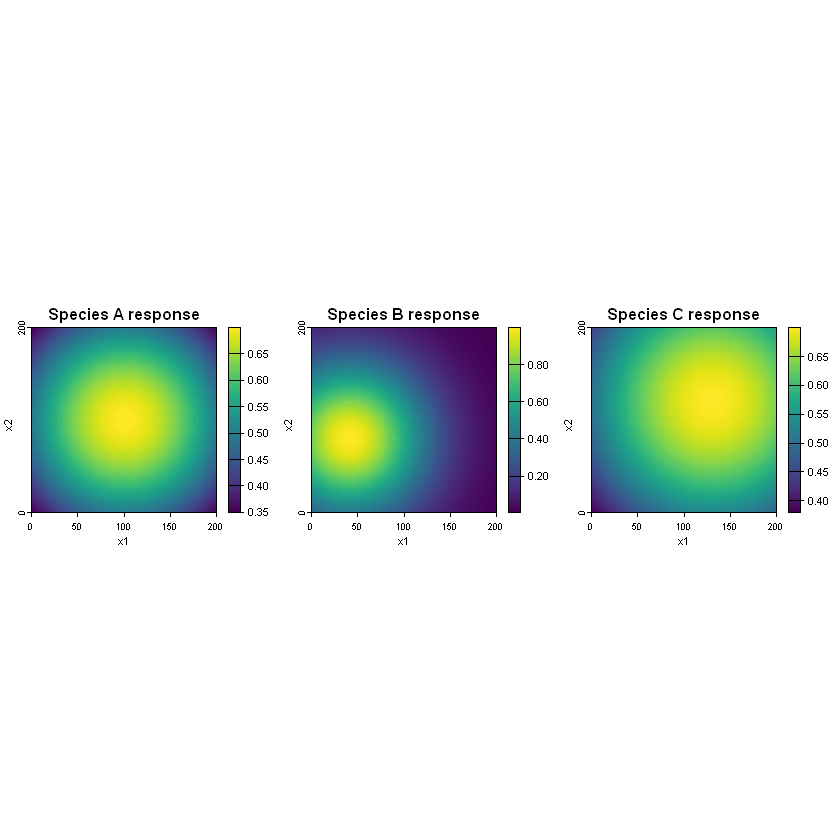

In [311]:
# Generate species response to environmental gradients

species_a <- function(x1, x2) {
  exp(-((x1 - 0.5)^2 + (x2 - 0.5)^2) / (2 * 0.6^2)) * 0.7
}

species_b <- function(x1, x2) {
  exp(-((x1 - 0.6)^2 + (x2 - 0.2)^2) / (2 * 0.3^2)) * 1 # Slightly shifted and narrower
}

species_c <- function(x1, x2) {
  exp(-((x1 - 0.4)^2 + (x2 - 0.65)^2) / (2 * 0.8^2)) * 0.7 # Quite different peak location
}

# Visualising the relationships
# Create a grid of x1 and x2 values
x1_vals <- seq(0, 1, length.out = 200)
x2_vals <- seq(0, 1, length.out = 200)
grid <- expand.grid(x1 = x1_vals, x2 = x2_vals)

# Calculate the function values for each species
species_a_response <- species_a(grid$x1, grid$x2)
species_b_response <- species_b(grid$x1, grid$x2)
species_c_response <- species_c(grid$x1, grid$x2)

# Visualize using contour plots with white backgrounds
par(mfrow = c(1, 3), bg = "white") # Set background to white for all plots

plot(
    terra::rast(
        matrix(species_a_response, nrow = length(x1_vals))
    ),
    main = "Species A response",
    xlab = "x1",
    ylab = "x2"
)
plot(
    terra::rast(
        matrix(species_b_response, nrow = length(x1_vals))
    ),
    main = "Species B response",
    xlab = "x1",
    ylab = "x2"
)
plot(
    terra::rast(
        matrix(species_c_response, nrow = length(x1_vals))
    ),
    main = "Species C response",
    xlab = "x1",
    ylab = "x2"
)


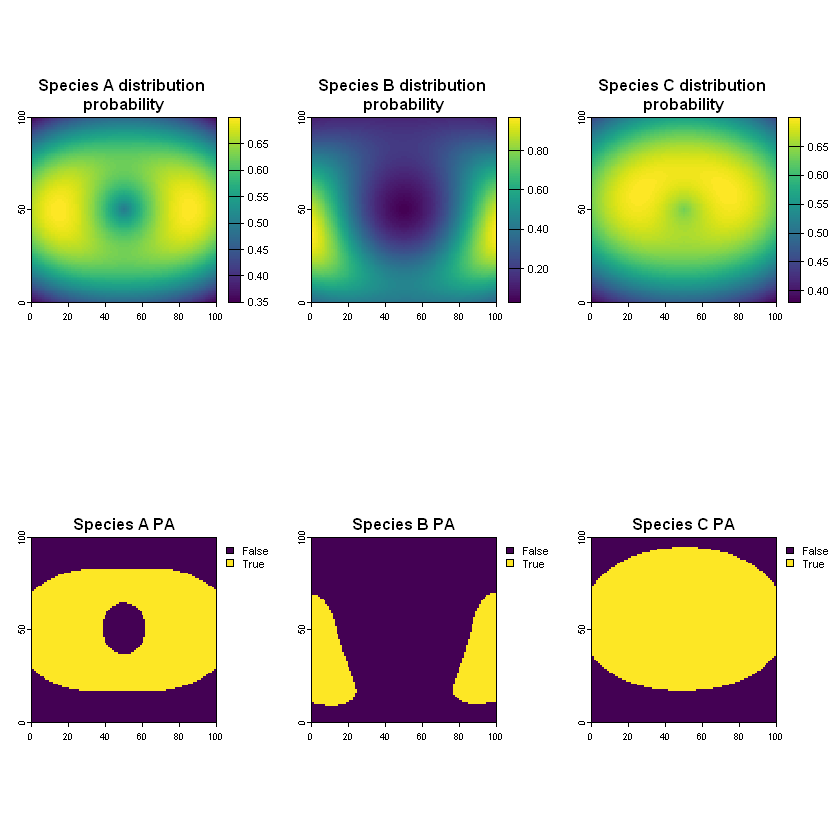

In [312]:
# Generate the species distributions
true_a_dist_prob <- species_a(env_1, env_2)
true_b_dist_prob <- species_b(env_1, env_2)
true_c_dist_prob <- species_c(env_1, env_2)

# Thresholded distributions
true_a_pa <- true_a_dist_prob > threshold
true_b_pa <- true_b_dist_prob > threshold
true_c_pa <- true_c_dist_prob > threshold

# Visualize the species distributions
par(mfrow = c(2, 3), bg = "white") # Set background to white for all plots
plot(true_a_dist_prob, main = "Species A distribution \nprobability")
plot(true_b_dist_prob, main = "Species B distribution \nprobability")
plot(true_c_dist_prob, main = "Species C distribution \nprobability")

plot(true_a_pa, main = "Species A PA")
plot(true_b_pa, main = "Species B PA")
plot(true_c_pa, main = "Species C PA")



Now, we want to artificially supress the occurrence of some of the species in some locations to simulate the dark diversity. We will multiply the species distributions by one of the dark diversity covariates.

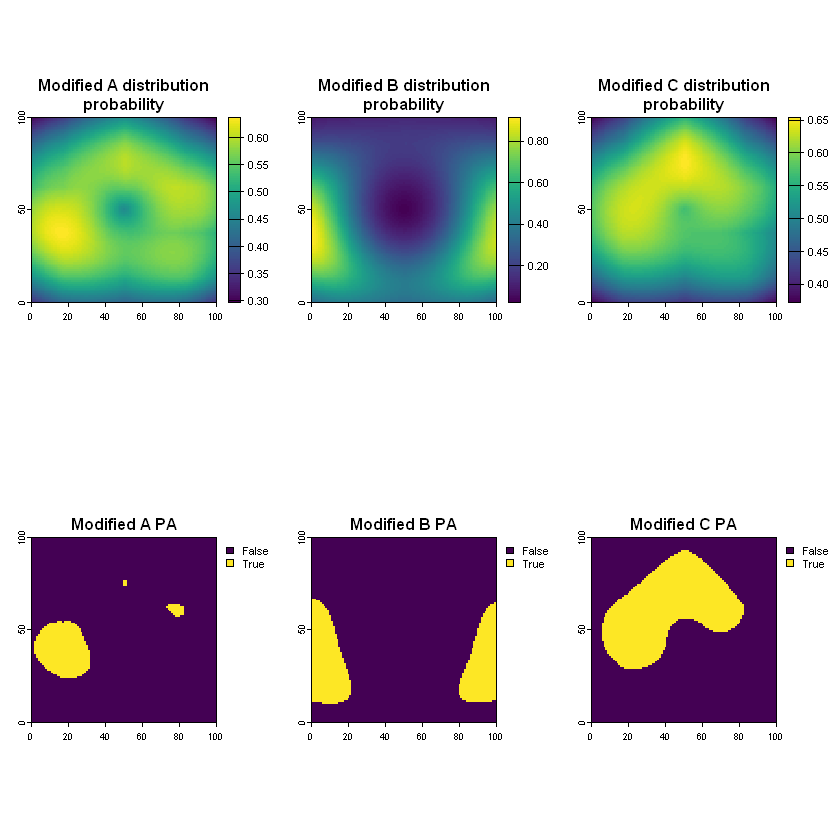

In [313]:
mod_a_dist_prob <- true_a_dist_prob * d1
mod_b_dist_prob <- true_b_dist_prob * d2
mod_c_dist_prob <- true_c_dist_prob * (d1 + d2) / 2

mod_a_pa <- mod_a_dist_prob > threshold
mod_b_pa <- mod_b_dist_prob > threshold
mod_c_pa <- mod_c_dist_prob > threshold

par(mfrow = c(2, 3), bg = "white")
plot(mod_a_dist_prob, main = "Modified A distribution\nprobability")
plot(mod_b_dist_prob, main = "Modified B distribution\nprobability")
plot(mod_c_dist_prob, main = "Modified C distribution\nprobability")
plot(mod_a_pa, main = "Modified A PA")
plot(mod_b_pa, main = "Modified B PA")
plot(mod_c_pa, main = "Modified C PA")


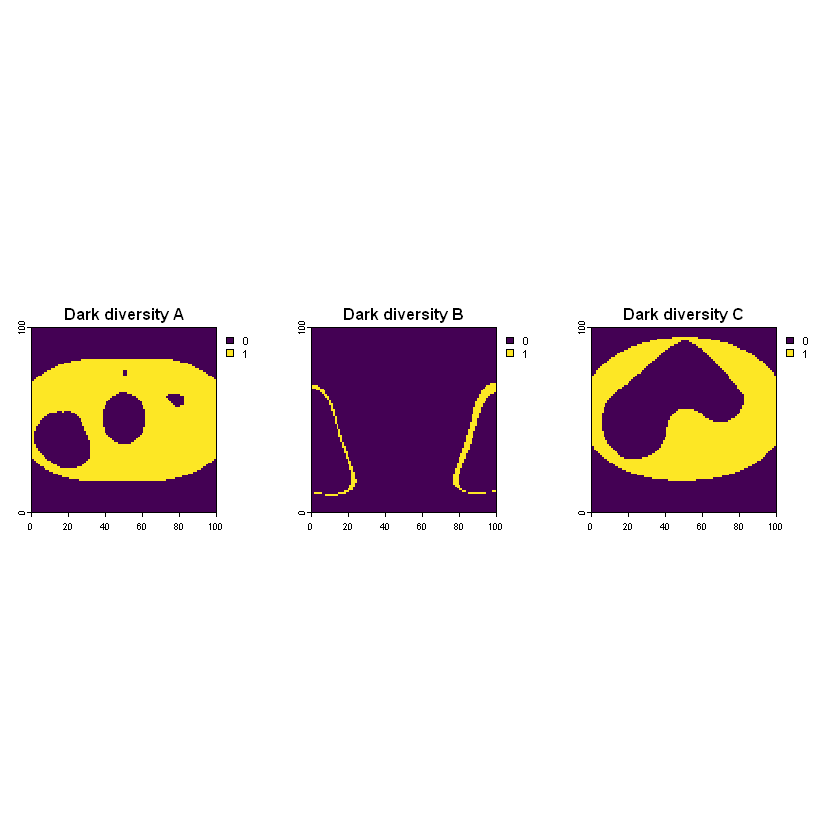

In [314]:
# Subtract the modified PA from the true PA to show where the dark diversity is
dark_div_a <- (true_a_pa - (mod_a_dist_prob > threshold))
dark_div_b <- (true_b_pa - (mod_b_dist_prob > threshold))
dark_div_c <- (true_c_pa - (mod_c_dist_prob > threshold))

par(mfrow = c(1, 3), bg = "white")
plot(dark_div_a, main = "Dark diversity A")
plot(dark_div_b, main = "Dark diversity B")
plot(dark_div_c, main = "Dark diversity C")

Now we have these distributions, we can sample from them to create plot level presence/absence data.

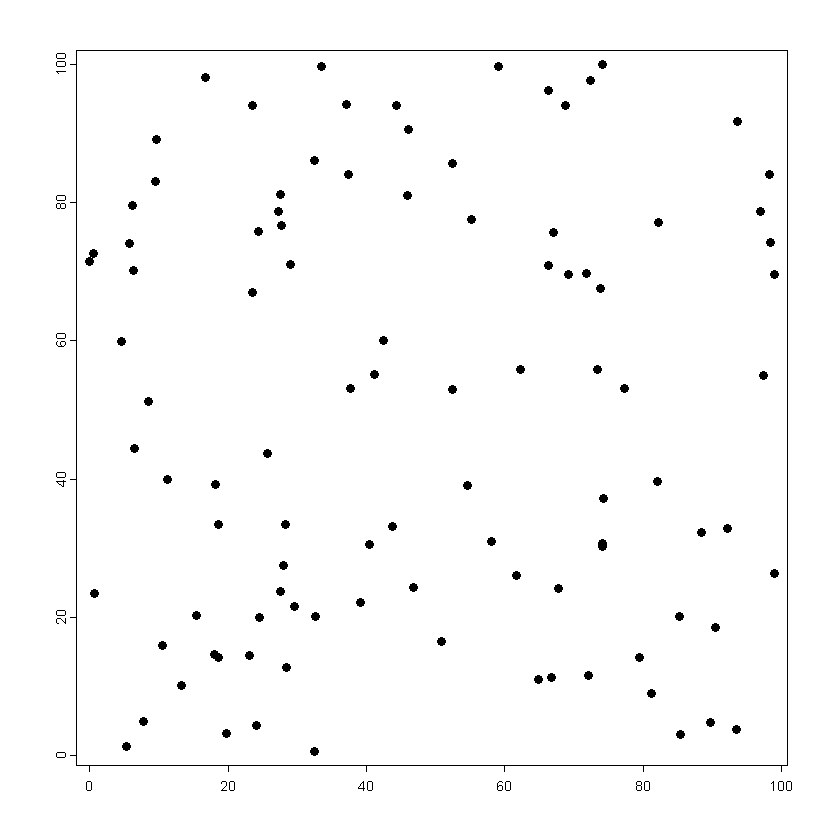

In [315]:
env_1_ext <- ext(env_1)
all_plots <- data.frame(
    x = runif(100000, env_1_ext[1], env_1_ext[2]),
    y = runif(100000, env_1_ext[3], env_1_ext[4])
) |> terra::vect(geom = c("x", "y"))


plots <- sample(all_plots, n_plots)

par(bg = "white")
plot(plots)

In [316]:
# Sample observations from the real presence absence
species_a_obs <- terra::extract(mod_a_pa, plots)[, -1]
species_b_obs <- terra::extract(mod_b_pa, plots)[, -1]
species_c_obs <- terra::extract(mod_c_pa, plots)[, -1]

plot_observations <- data.frame(
    species_a_pa = species_a_obs,
    species_b_pa = species_b_obs,
    species_c_pa = species_c_obs
)

env <- data.frame(
    env_1 = terra::extract(env_1, plots)[, -1],
    env_2 = terra::extract(env_2, plots)[, -1]
)
    

head(plot_observations)
head(env)

,species_a_pa,species_b_pa,species_c_pa
,<lgl>,<lgl>,<lgl>
1,FALSE,FALSE,TRUE
2,FALSE,TRUE,FALSE
3,TRUE,FALSE,TRUE
4,FALSE,FALSE,FALSE
5,FALSE,FALSE,FALSE
6,FALSE,FALSE,TRUE


,env_1,env_2
,<dbl>,<dbl>
1,0.14521452,0.5032103
2,0.40044004,0.3510008
3,0.66186619,0.5000000
4,0.00330033,0.2710281
5,0.15981598,0.1565547
6,0.46374637,0.8250714


Now we can create the species pool probability using the DarkDiv package

In [317]:
library(DarkDiv)

pool <- DarkDiv(plot_observations)$Pool
# Where the species is absent, DarkDiv returns NaN, but we want to replace it with 0
pool[is.na(pool)] <- 0
head(pool)


species_a_pa,species_b_pa,species_c_pa
0.9999805,0.2364556,1.0000000
0.9573482,1.0000000,0.2364556
1.0000000,0.6919831,1.0000000
0.0000000,0.0000000,0.0000000
0.0000000,0.0000000,0.0000000
0.9999805,0.2364556,1.0000000


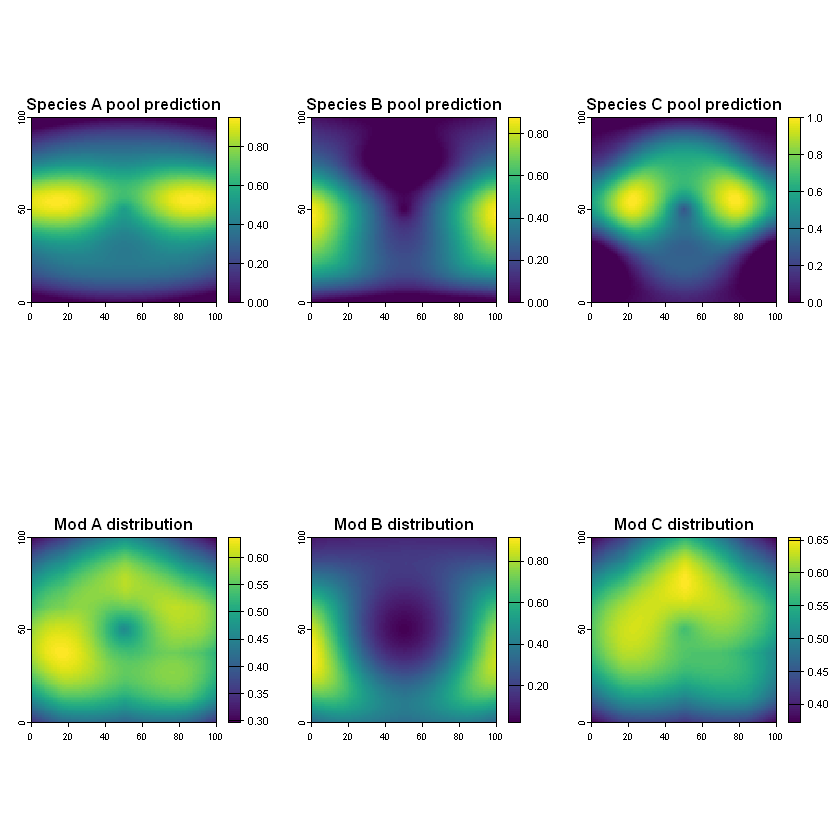

In [318]:
# Construct the species pool raster predictions (using a simple GAM model)
library(mgcv)

envs <- c(env_1, env_2)
names(envs) <- c("env_1", "env_2")

gam_a <- gam(species_a_pa ~ s(env_1) + s(env_2), data = cbind(pool, env))
gam_b <- gam(species_b_pa ~ s(env_1) + s(env_2), data = cbind(pool, env))
gam_c <- gam(species_c_pa ~ s(env_1) + s(env_2), data = cbind(pool, env))

# Now predict out the species pool predictions
pool_a <- predict(envs, gam_a, type = "response") |> terra::clamp(0, 1)
pool_b <- predict(envs, gam_b, type = "response") |> terra::clamp(0, 1)
pool_c <- predict(envs, gam_c, type = "response") |> terra::clamp(0, 1)

par(mfrow = c(2, 3), bg = "white")
plot(pool_a, main = "Species A pool prediction")
plot(pool_b, main = "Species B pool prediction")
plot(pool_c, main = "Species C pool prediction")
plot(mod_a_dist_prob, main = "Mod A distribution")
plot(mod_b_dist_prob, main = "Mod B distribution")
plot(mod_c_dist_prob, main = "Mod C distribution")


Now we have our predictions for where a species is likely to be in the species pool, we can use the occurrence records to model the known presence of a species.

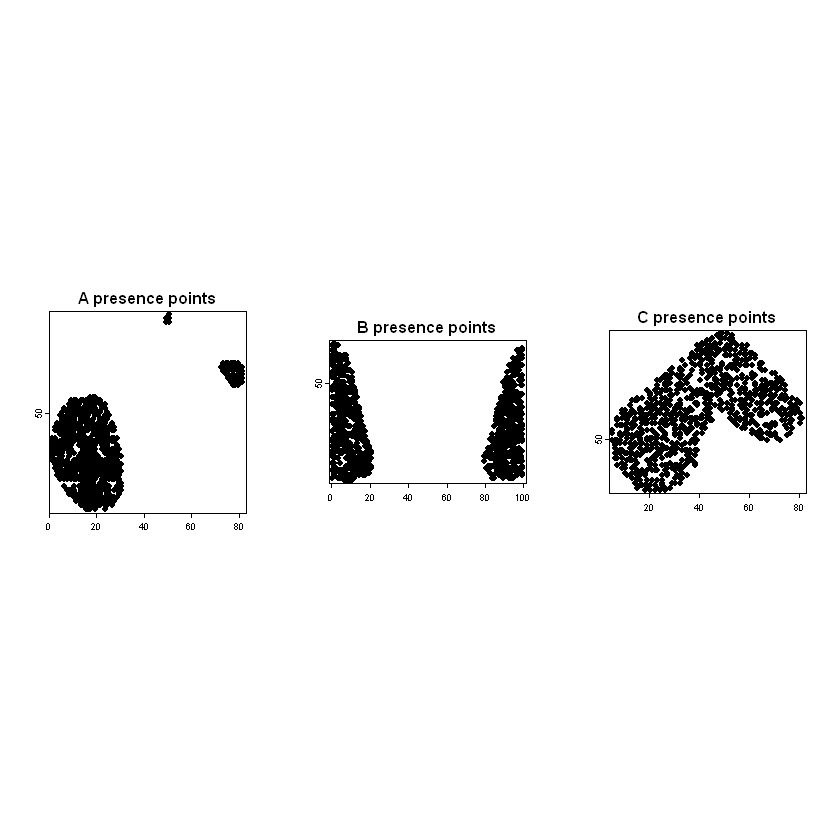

In [319]:
sample_pres <- function(x, n = 1000) {
    # Get cell indices where value == 1
    cells <- which(values(x) == 1)
    # Randomly sample n of those cell indices
    sampled_cells <- sample(cells, n, replace = TRUE)
    # Get coordinates of those cells
    coords <- xyFromCell(x, sampled_cells)
    # Optionally, convert to SpatVector points
    pres <- terra::vect(coords)
    return(pres)
}

a_pres <- sample_pres(mod_a_pa, n_pts)
b_pres <- sample_pres(mod_b_pa, n_pts)
c_pres <- sample_pres(mod_c_pa, n_pts)

par(mfcol = c(1, 3), bg = "white")
plot(a_pres, main = "A presence points")
plot(b_pres, main = "B presence points")
plot(c_pres, main = "C presence points")

Warning message:
"data contain duplicated points"
Warning message:
"data contain duplicated points"
Warning message:
"data contain duplicated points"


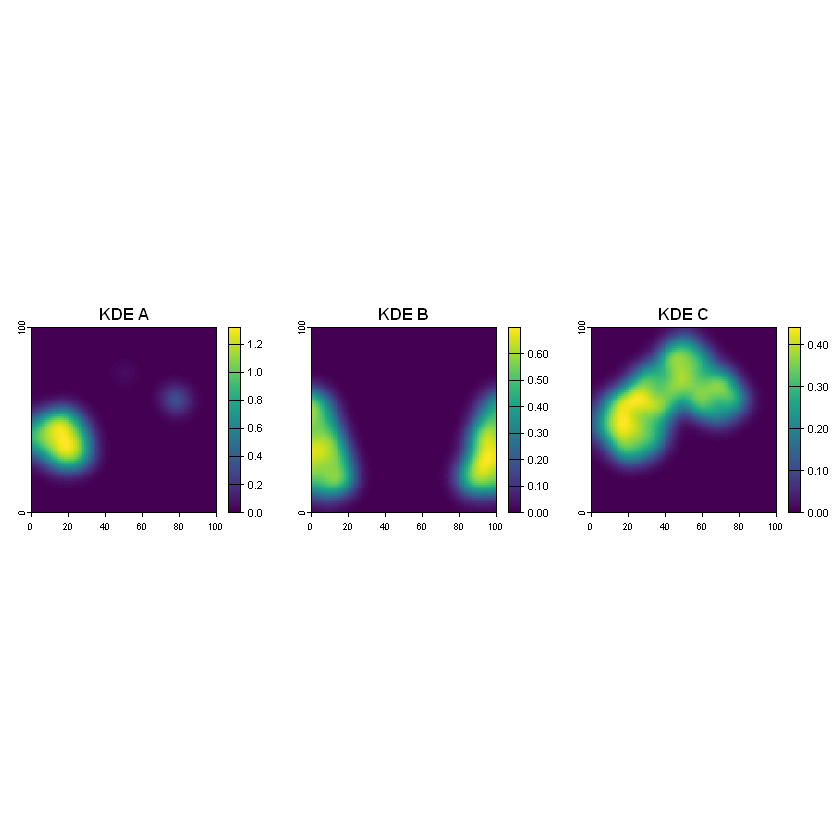

In [320]:
# Convert terra::vect points to spatstat point patterns (ppp)
library(spatstat)

# Convert terra::vect to data.frame for spatstat
a_coords <- as.data.frame(terra::crds(a_pres))
b_coords <- as.data.frame(terra::crds(b_pres))
c_coords <- as.data.frame(terra::crds(c_pres))

# Define the window (observation region) based on raster extent
win <- owin(
  xrange = c(terra::ext(env_1)[1], terra::ext(env_1)[2]),
  yrange = c(terra::ext(env_1)[3], terra::ext(env_1)[4])
)

# Create spatstat point patterns
a_ppp <- ppp(a_coords$x, a_coords$y, window = win)
b_ppp <- ppp(b_coords$x, b_coords$y, window = win)
c_ppp <- ppp(c_coords$x, c_coords$y, window = win)

# Calculate kernel density estimates
kde_a <- density(a_ppp, sigma = sigma)
kde_b <- density(b_ppp, sigma = sigma)
kde_c <- density(c_ppp, sigma = sigma)

# Convert spatstat KDE (im object) to terra raster
kde_a_rast <- rast(apply(as.matrix(kde_a), 2, rev), extent = ext(env_1))
crs(kde_a_raster) <- crs(env_1)
names(kde_a_rast) <- "kde"
kde_a_rast <- resample(kde_a_rast, env_1)

kde_b_rast <- rast(apply(as.matrix(kde_b), 2, rev), extent = ext(env_1))
crs(kde_b_raster) <- crs(env_1)
names(kde_b_rast) <- "kde"
kde_b_rast <- resample(kde_b_rast, env_1)

kde_c_rast <- rast(apply(as.matrix(kde_c), 2, rev), extent = ext(env_1))
crs(kde_c_raster) <- crs(env_1)
names(kde_c_rast) <- "kde"
kde_c_rast <- resample(kde_c_rast, env_1)

# Plot to check orientation
par(mfrow = c(1, 3), bg = "white")
plot(kde_a_rast, main = "KDE A")
plot(kde_b_rast, main = "KDE B")
plot(kde_c_rast, main = "KDE C")


Now we have our kernel density estimates for the known presence of all three species. Now we can fit these to a model to get the known presence of each species. Ideally we can use MaxEnt, but for simplicity we will use the same GAM approach as before. But this means we will have to generate some psuedo-absences for the known presence model.

In [321]:
pseudo_a_pts <- sample(all_plots, n_pts)
pseudo_b_pts <- sample(all_plots, n_pts)
pseudo_c_pts <- sample(all_plots, n_pts)

sp_a_pres_df <- data.frame(
    terra::extract(envs, a_pres)[, -1],
    kde =  terra::extract(kde_a_rast, a_pres)[, -1],
    pa = 1
)
sp_a_abs_df <- data.frame(
    terra::extract(envs, pseudo_a_pts)[, -1],
    kde = terra::extract(kde_a_rast, pseudo_a_pts)[, -1],
    pa = 0
)
sp_a_df <- rbind(sp_a_pres_df, sp_a_abs_df)

sp_b_pres_df <- data.frame(
    terra::extract(envs, b_pres)[, -1],
    kde = terra::extract(kde_b_rast, b_pres)[, -1],
    pa = 1
)
sp_b_abs_df <- data.frame(
    terra::extract(envs, pseudo_b_pts)[, -1],
    kde = terra::extract(kde_b_rast, pseudo_b_pts)[, -1],
    pa = 0
)
sp_b_df <- rbind(sp_b_pres_df, sp_b_abs_df)

sp_c_pres_df <- data.frame(
    terra::extract(envs, c_pres)[, -1],
    kde = terra::extract(kde_c_rast, c_pres)[, -1],
    pa = 1
)
sp_c_abs_df <- data.frame(
    terra::extract(envs, pseudo_c_pts)[, -1],
    kde = terra::extract(kde_c_rast, pseudo_c_pts)[, -1],
    pa = 0
)
sp_c_df <- rbind(sp_c_pres_df, sp_c_abs_df)


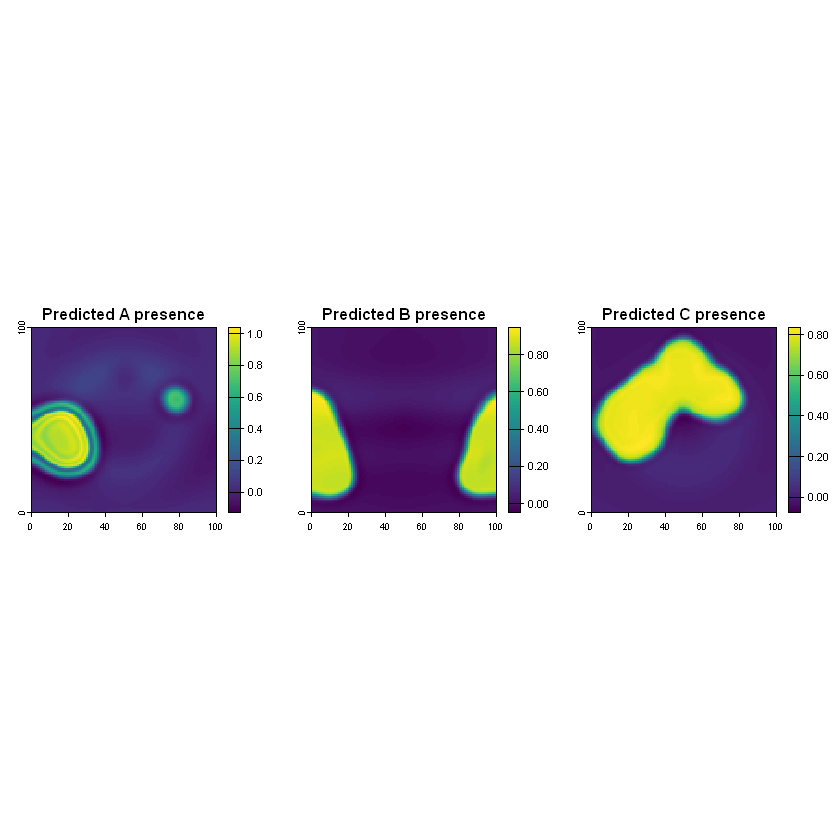

In [322]:
sp_a_envs <- c(envs, kde_a_rast)
sp_b_envs <- c(envs, kde_b_rast)
sp_c_envs <- c(envs, kde_c_rast)

# Fit GAMs to the species data
gam_a <- gam(pa ~ s(env_1) + s(env_2) + s(kde), data = sp_a_df)
gam_b <- gam(pa ~ s(env_1) + s(env_2) + s(kde), data = sp_b_df)
gam_c <- gam(pa ~ s(env_1) + s(env_2) + s(kde), data = sp_c_df)

# Predict the species distributions using the fitted GAMs
pred_a_pres <- predict(sp_a_envs, gam_a, type = "response")
pred_b_pres <- predict(sp_b_envs, gam_b, type = "response")
pred_c_pres <- predict(sp_c_envs, gam_c, type = "response")

# Plot the predictions
par(mfrow = c(1, 3), bg = "white")
plot(pred_a_pres, main = "Predicted A presence")
plot(pred_b_pres, main = "Predicted B presence")
plot(pred_c_pres, main = "Predicted C presence")

Now we have our predicted presence of each species, we can subtract this from the species pool to get the assumed absence dark diversity.

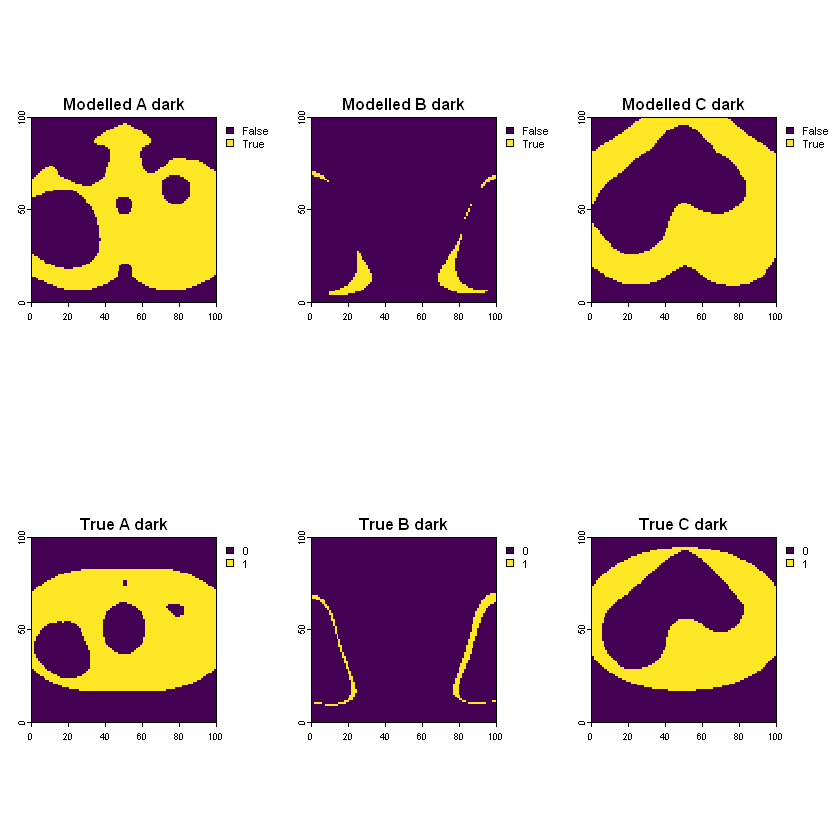

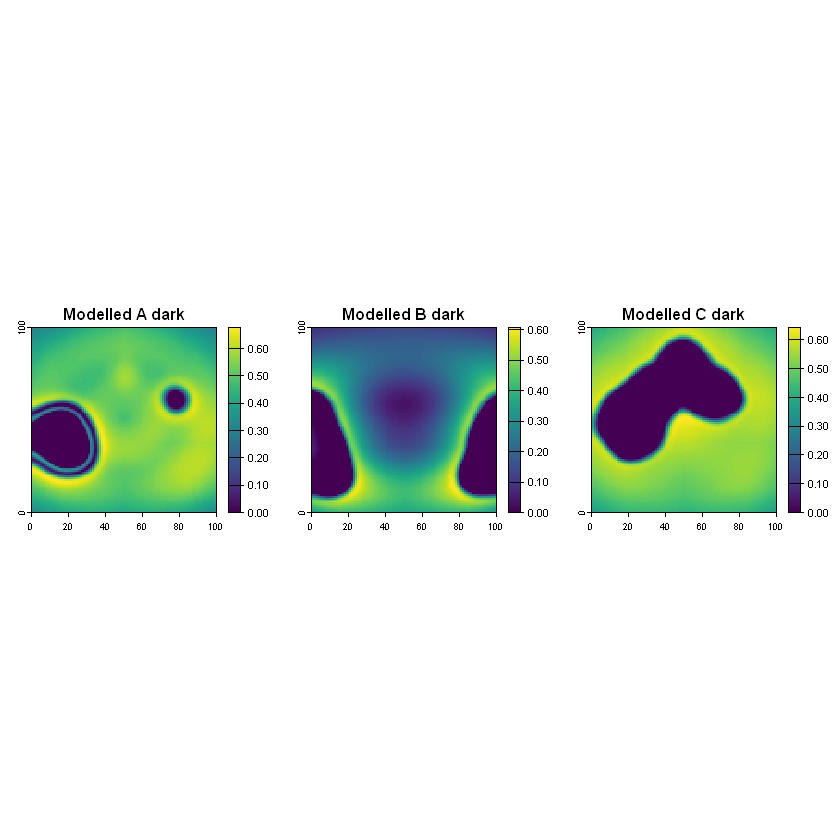

In [324]:
mod_dark_a <- (mod_a_dist_prob - pred_a_pres) |> terra::clamp(0, 1)
mod_dark_a_pa <- mod_dark_a > dark_threshold

mod_dark_b <- (mod_b_dist_prob - pred_b_pres) |> terra::clamp(0, 1)
mod_dark_b_pa <- mod_dark_b > dark_threshold

mod_dark_c <- (mod_c_dist_prob - pred_c_pres) |> terra::clamp(0, 1)
mod_dark_c_pa <- mod_dark_c > dark_threshold

par(mfrow = c(2, 3), bg = "white")
plot(mod_dark_a_pa, main = "Modelled A dark")
plot(mod_dark_b_pa, main = "Modelled B dark")
plot(mod_dark_c_pa, main = "Modelled C dark")
plot(dark_div_a, main = "True A dark")
plot(dark_div_b, main = "True B dark")
plot(dark_div_c, main = "True C dark")

par(mfrow = c(1, 3), bg = "white")
plot(mod_dark_a, main = "Modelled A dark")
plot(mod_dark_b, main = "Modelled B dark")
plot(mod_dark_c, main = "Modelled C dark")

This method far better captures the true patterns of dark diversity than any of the previous methods. With more plot samples for modelling the species pool, the model will get even better.

Another way to improve the method is to use a more complex/better model for modelling the species pool as well as the known presence. A gaussian process model may be much better for the species pool, and a MaxEnt model may be better for the known presence because it is designed for presence-only data.

The number of presence records is also important, as the more presence records we have, the better the model will be at predicting the known presence.

The bandwidth of the kernel density estimate is also important, as it determines how smooth the probability for presence are. This can be interpreted as the disperal distance of the species, so species with larger dispersal distances will have a larger bandwidth, and species with smaller dispersal distances will have a smaller bandwidth.